In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.spatial.distance import cdist



class KNNgraph():
    def __init__(self,X,k = 5,max_iter = 100,dist_metric = 'euclidean'):
        
        assert k > 0 and k<len(X), "Value of k should lie between 0 and {0}".format(len(X)-1)
        
        self.X = X
        self.k = k
        self.max_iter = max_iter
        self.metric = dist_metric
     
    
    def find_neighbours(self):
        dist_mat = self._calc_distance()
        neighbours_list = [self._get_neighbours(i,dist_mat) for i in range(len(self.X))]
        
        return np.array(neighbours_list)
    
    def create_graph(self,format = 'adjacency_matrix'):
        """
        Returns Adjacency Matrix 
        """
        
        
        n = len(self.X)
        dist_mat = self._calc_distance()
        adj =  np.zeros((n, n)) + np.inf
        nb = self.find_neighbours()
        
        temp = np.full((n,n), False, dtype=bool)
        if format == 'adjacency_matrix':
            for i in range(n):
                for j in range(self.k):
                    nth = nb[i,j]
                    temp[i,nth] = True
                    
            adj[temp] = dist_mat[temp]
            return adj
               
    
    def _get_neighbours(self,i,dist_mat):
        current_data = self.X[i]
        dist_to_neighbours = dist_mat[i]
        index = dist_to_neighbours.argsort()
        
        allowed_indices = index<=self.k
        allowed_indices[i] = False # Falsify the distance of the point to itself
        
        #Calculate Neighbours
        comp_ind = np.arange(len(self.X))
        neighbours = comp_ind[allowed_indices]
        
        #Start from 1 since the position 0 represents the point i itself
        neighbours = index[1:self.k+1]
        
        return neighbours 
        
        
        
        
    def _calc_distance(self):
        dist = cdist(self.X, self.X, metric=self.metric)
        return dist

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.spatial.distance import cdist
from sklearn.utils.graph_shortest_path import graph_shortest_path
import sys
sys.path.insert(0, '../../DimensionalRed/PCA/')
sys.path.insert(0, '../../DimensionalRed/MDS/')

from pca import PCA
from mds import MDS


class Isomap():
    
    
    def __init__(self,X,num_dim=2,k = 5,dist_func = 'euclidean',eps = None):
        self.X = X
        self.d = num_dim
        self.k = k #K-neighbours
        self.metric = dist_func
        
        if eps!=None:
            self.distance_matrix = self._make_adjacency_eps(eps = eps)
        else:
            self.distance_matrix = self._make_adjacency_knn()
        
        
    
    
    def _make_adjacency_eps(self, eps=1):
        
        
        """
        Step one of ISOMAP algorithm, make Adjacency and distance matrix
        Compute the WEIGHTED adjacency matrix A from the given data points.  Points
        are considered neighbors if they are within epsilon of each other.  Distance
        between points will be calculated using SciPy's cdist which will
        compute the D matrix for us. 
        INPUT
        ------
         data - (ndarray) the dataset which should be a numpy array
         dist_func - (str) the distance metric to use. See SciPy cdist for list of
                     options
         eps - (int/float) epsilon value to define the local region. I.e. two points
                           are connected if they are within epsilon of each other.
        OUTPUT
        ------
         short - (ndarray) Distance matrix, the shortest path from every point to
             every other point in the set, INF if not reachable. 
        """
    
        n, d = self.X.shape
        dist = cdist(self.X,self.X, metric=self.metric)
        adj =  np.zeros((n, n)) + np.inf
        bln = dist < eps
        print(bln)
        adj[bln] = dist[bln]
        print(adj)
        short = graph_shortest_path(adj)
        print(short)

        return short
    
    def _make_adjacency_knn(self):
    
        knn_graph = KNNgraph(self.X,self.k,dist_metric = self.metric)
        adj = knn_graph.create_graph()
        short = graph_shortest_path(adj)
        return short
    
    def shortest_distance(self):
        return self._make_adjacency_knn()


    def project(self,technique='pca'):


        """
        take an adjacency matrix and distance matrix and compute the ISOMAP
        algorithm

        Take the shortest path distance matrix. This follows from the algorithm in
        class, create a centering matrix and apply it to the distance matrix D. Then
        we can compute the C matrix which will be used for the eigen-decomposion
        Find out more 

        INPUT
        ------
          d - (ndarray) Distance matrix between nodes. Should be square.
          dim - (int) how many dimensions to reduce down too

        OUTPUT
        ------
          z - (ndarray) data projection into new reduced space. Each row maps back
              to one of the origional datapoints
        """

#         n, d = self.distance_matrix.shape

#         #Calculate data centering matrix
#         h = np.eye(n) - (1/n)*np.ones((n, n))
#         d_2 = self.distance_matrix**2
#         c = -1/(2*n) * h.dot(d_2).dot(d_2)

        if technique == 'pca':
            pca = PCA(-0.5*self.distance_matrix**2,self.d)
            proj = pca.project()
            

    #         evals, evecs = linalg.eig(c)
    #         idx = evals.argsort()[::-1]
    #         evals = evals[idx]
    #         evecs = evecs[:, idx]
    #         evals = evals[:self.d] 
    #         evecs = evecs[:, :self.d]
    #         z = evecs.dot(np.diag(evals**(-1/2)))
        elif technique == 'mds':
            mds = MDS(-0.5*self.distance_matrix**2,self.d)
            proj = mds.project()
            
        elif technique == 'kpca':
            kpca = KPCA(self.X,self.distance_matrix,self.d)
            proj = pca.project()

        return proj


    
    

In [3]:
X = np.array([[1,2],[7,8],[5,6],[3,4]])

knn = KNNgraph(X,2)
knn.find_neighbours()
knn.create_graph()

array([[       inf,        inf, 5.65685425, 2.82842712],
       [       inf,        inf, 2.82842712, 5.65685425],
       [       inf, 2.82842712,        inf, 2.82842712],
       [2.82842712,        inf, 2.82842712,        inf]])

In [4]:
X = np.array([[1,2],[7,8],[5,6],[3,4]])

i = 2
current_data = X[i]
dist = cdist(X, X, metric='euclidean')
distance_to_neighbours = dist[i]
print(distance_to_neighbours)

index = distance_to_neighbours.argsort()
print(index)

dist
allowed_indices = index <=2

z = np.full(len(X), False, dtype=bool)
z[allowed_indices]
print(z)

allowed_indices[i] = False
print(allowed_indices)

comp_ind = np.arange(len(X))
comp_ind[allowed_indices]

index[1:2+1]

[5.65685425 2.82842712 0.         2.82842712]
[2 1 3 0]
[False False False False]
[ True  True False  True]


array([1, 3], dtype=int64)

In [5]:
from sklearn.datasets import load_digits
digits = load_digits()


X,y = digits['data'], digits['target']

In [6]:
im = Isomap(X,num_dim = 2,k = 10)

In [7]:
im.project('pca')

array([[1431552.05612054,  190556.05773612],
       [-333712.67884453,  -68956.8088067 ],
       [-384927.35400621,   70691.64081702],
       ...,
       [-372416.38800603,  -31937.92158865],
       [-383191.86503356,   94011.17923269],
       [-412277.97829287,  162435.24235442]])

In [8]:
im.project('mds')

array([[2024520.33300875, -269486.96124276],
       [-471940.99635781,   97519.65423241],
       [-544369.48456397,  -99973.07718983],
       ...,
       [-526676.30676813,   45167.04186467],
       [-541915.13252149, -132951.88468556],
       [-583049.10836954, -229718.12274498]])

In [9]:
z = im.shortest_distance()

In [10]:
z

array([[  0.        , 281.23986585, 332.27704842, ..., 345.14165907,
        330.52269332, 389.13701919],
       [280.26073608,   0.        , 117.16498807, ...,  95.34368723,
        136.78510112, 146.6398793 ],
       [204.54340577,  98.41439472,   0.        , ...,  91.79388082,
        176.12135499, 128.5493543 ],
       ...,
       [265.90680273, 116.40355763, 126.89016816, ...,   0.        ,
        134.21974411, 110.2200485 ],
       [205.24424592, 154.17653496, 163.66591612, ...,  86.89938587,
          0.        , 136.06314222],
       [200.68684728, 143.82878544, 127.81106764, ...,  28.87905816,
        126.82147635,   0.        ]])

In [11]:
from sklearn.manifold import Isomap
embedding = Isomap(n_neighbors=10)
X_transformed = embedding.fit_transform(X)
X_transformed.shape

(1797, 2)

In [12]:
X_transformed

array([[ 99.02204132, -31.42076495],
       [-26.63601926,  46.9158799 ],
       [-33.77388503,   3.30857164],
       ...,
       [-43.1047666 ,   0.98381667],
       [-31.82563787, -52.3715874 ],
       [-21.42831743, -27.99208091]])

In [13]:
colors = []
X_im = im.project('pca')
X_mds = im.project('mds')
X_ = []
X_t = []
X_m = []
y_ = []
for i in range(len(y)):
    if y[i] == 1:
        X_.append(X_im[i])
        X_t.append(X_transformed[i])
        X_m.append(X_mds[i])
        y_.append(1)
        colors.append('#FFB300')
    elif y[i] == 2:
        X_.append(X_im[i])
        X_t.append(X_transformed[i])
        X_m.append(X_mds[i])
        y_.append(2)
        colors.append('#E64A19')
    elif y[i] == 0:
        X_.append(X_im[i])
        X_t.append(X_transformed[i])
        X_m.append(X_mds[i])
        y_.append(0)
        colors.append('#00FF00')

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def plot_scores_2d(data, colors, grid = True, dim_1 = 1, dim_2 = 2):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(15,10))
    plt.axhline(c = 'black', alpha = 0.2)
    plt.axvline(c = 'black', alpha = 0.2)
    plt.scatter(data.T[dim_1 - 1,:], data.T[dim_2 - 1,:], c = colors)
    plt.grid(grid)
    plt.title('Random Projection')
    plt.xlabel('{}st dimension'.format(dim_1))
    plt.ylabel('{}nd dimension'.format(dim_2))
    plt.show()

pca


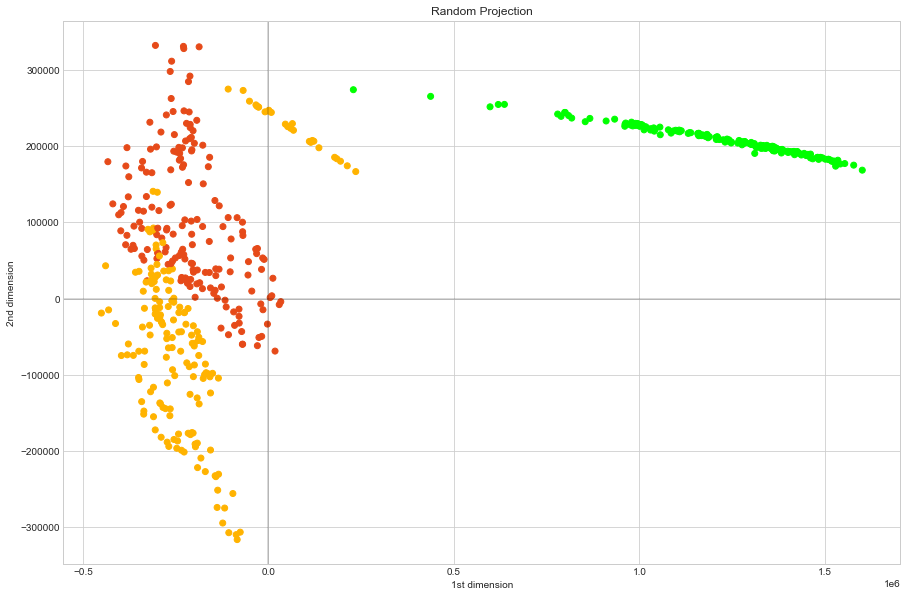

mds


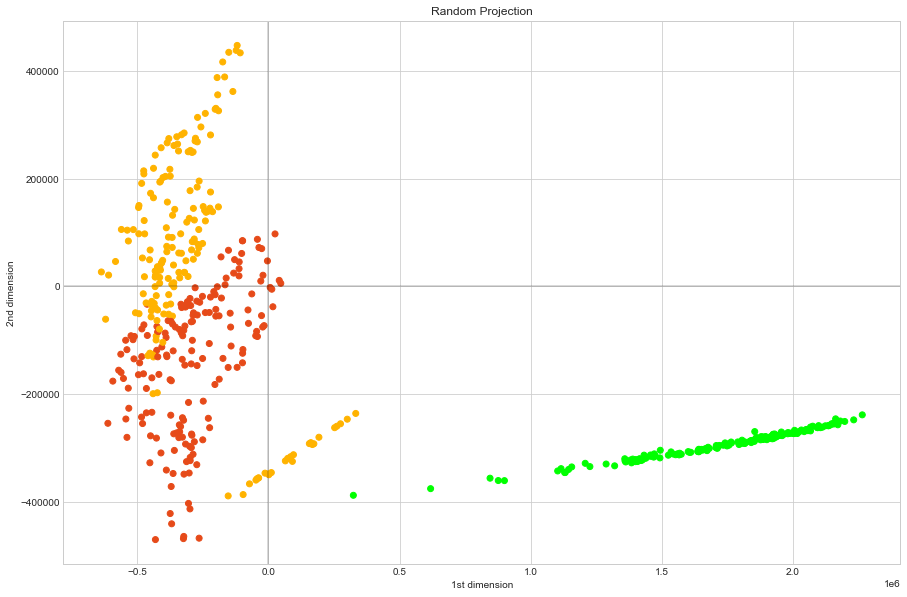

scikit-isomap


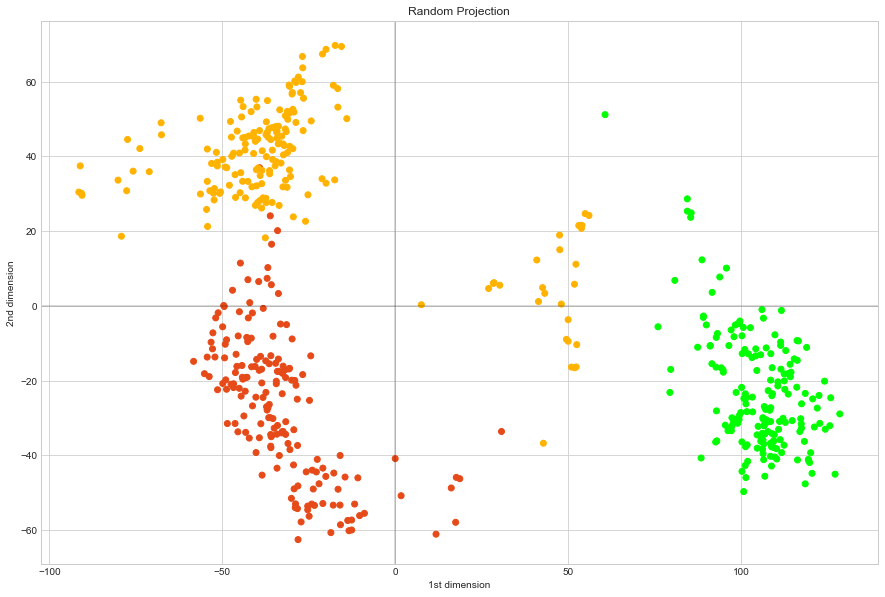

In [15]:
print('pca')
plot_scores_2d(np.array(X_),colors)

print('mds')
plot_scores_2d(np.array(X_m),colors)

print('scikit-isomap')
plot_scores_2d(np.array(X_t),colors)

In [16]:
len(X_)

537